In [2]:
from support import *

import numpy as np

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry
from photutils.psf import CircularGaussianPRF

import matplotlib.pyplot as plt

from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord

from astropy.coordinates import Angle
import astropy.units as u

import pandas as pd

In [ ]:
fname = ['R2048554P.fit']
# Read fits
ffile = fits.open(f'{fname[0]}')
data = ffile[0].data.transpose()
head = ffile[0].header

In [4]:
head

SIMPLE  =                    T                                                  
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  576                                                  
NAXIS2  =                  768                                                  
                                                                                
BSCALE  =                  1.0                                                  
BZERO   =                    0                                                  
DATAMIN =                    0                                                  
DATAMAX =                65535                                                  
TYPE    =                       1                                               
                                                                                
DATE-OBS= '2024-04-27'      

In [5]:
#Координати центру
coord = SkyCoord(f'{head["RA"]} {head["DEC"]}', 
                 unit=("hourangle","deg"), 
                 frame="icrs", 
                 obstime=f'{head["DATE-OBS"]}T{head["TIME-OBS"]}'
)
#Кидаємо запит до Vizier, щоб витягнути зірки з каталогу Tycho2, які мають яскравість менше 6 mag
TYCHO2 = Vizier(catalog="I/350/tyc2tdsc")
# Критерій який скидує ліміт на кількість зірок 
TYCHO2.ROW_LIMIT = -1
# 
result = TYCHO2.query_region(coordinates=coord,
                          width=6*u.deg,height=6*u.deg,
                          column_filters={'BTmag': '<6'})


In [ ]:
19:03:35.513 +037:08:12.95

In [6]:
result[0]

IDTyc2,RAT,DET,pmRA,pmDE,EpRA1990,EpDE1990,CCDM,BTmag,VTmag,TDSC,WDS,PA,Sep,_RA.icrs,_DE.icrs
,deg,deg,mas / yr,mas / yr,yr,yr,,mag,mag,,,deg,arcsec,deg,deg
str14,float64,float64,float32,float32,float32,float32,str4,float32,float32,int32,str12,float32,float32,float64,float64
2650-714-1,282.90216833000,36.53909750000,-4.3,-0.3,1.68,1.72,,5.962,6.066,--,,--,--,282.90215346357,36.53909666667
2650-2146-1,283.43149444000,36.97172806000,1.8,-2.3,1.61,1.75,,5.388,5.549,49036,18537+3658,--,--,283.43150069835,36.97172167111
2652-1709-1,286.82554028000,36.10016833000,-0.7,-4.0,1.54,1.64,,5.111,5.235,49780,19073+3606,--,--,286.82553787347,36.10015721889
3119-2541-1,284.50792250000,38.26618361000,-4.9,1.0,1.57,1.61,,5.766,5.868,49280,18581+3813,350.1,160.58,284.50790516414,38.26618638778
3121-2285-1,288.43953639000,39.14597139000,-1.9,-0.7,1.54,1.61,,4.203,4.373,50197,19138+3909,--,--,288.43952958471,39.14596944556
3121-2287-1,289.09206278000,38.13372667000,-2.0,1.4,1.56,1.51,,5.962,4.476,50344,19164+3808,--,--,289.09205571700,38.13373055889


In [9]:
#Витягуємо значення координат 
radec = np.deg2rad(np.array([[result[0]["RAT"][i], result[0]["DET"][i]] for i in range(len(result[0]))]))

In [10]:
# Витягуємо з хедера локальний зоряний час
local_siderial_time = Angle(f'{head["TIME-SID"]} hours').to_value(u.rad)
# Координати центру кадру (принаймні, так думає система)
RA = Angle(f'{head["RA"]} hours').to_value(u.rad)
DEC = Angle(f'{head["DEC"]} deg').to_value(u.rad)

#RA = Angle(f'19:09:08.62924 hours').to_value(u.rad)
#DEC = Angle(f'+37:53:16.2397 deg').to_value(u.rad)
# Перехід від RA до часового куту
center_hour_angle = hour_ra_(RA,local_siderial_time)
center_declination = DEC

# 
fi = np.deg2rad(49.917611730650556)
center_A, center_h = equatorial_to_horizontal(center_hour_angle,center_declination,fi)

# Матриця повороту, яка повертає декартову систему так, щоб вісь Z була нормаллю до площини кадру
# Обчислюється як множення інших матриць повороту на основі координат кочки на сфері
rotation_matrix = matrix(-(np.pi/2.-center_h),"y") @ (
                            matrix(-center_A,"z") @ matrix(-(np.pi/2.-fi),"y"))

In [13]:
xyz = pd.DataFrame(columns=["x","y","z"])
for i in radec:
    # Перехід зі сферичної до декартової системи координат з множенням на матрицю повороту
    xyz = pd.concat([xyz,pd.DataFrame([rotation_matrix @ np.array(spherical_to_cartesian(1,hour_ra_(i[0],local_siderial_time),np.pi/2. - i[1]))],columns=["x","y","z"])])
    
# Перехід від декартової сист. коорд. до координат площини кадру
X,Y = cartesian_to_plane(xyz["x"].values,xyz["y"].values,naxis = (head["NAXIS1"],head["NAXIS2"]), fov=np.deg2rad((3,4)), orientation=(1,1))

C:\Users\lrikozavr\AppData\Local\Temp\ipykernel_6216\1913023683.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  xyz = pd.concat([xyz,pd.DataFrame([rotation_matrix @ np.array(spherical_to_cartesian(1,hour_ra_(i[0],local_siderial_time),np.pi/2. - i[1]))],columns=["x","y","z"])])


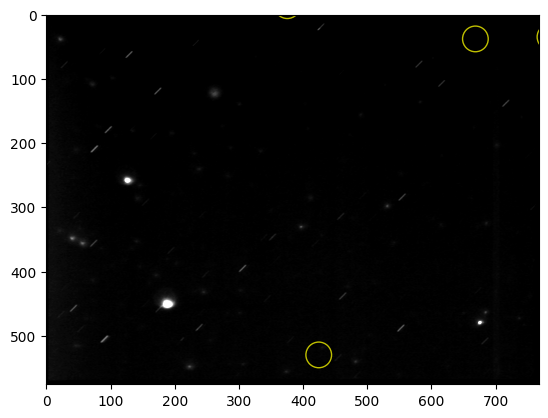

In [30]:
# формування списку координат для побудови зображення
xy = [[Y[i], X[i]] for i in range(len(X))]
# Draw data
plt.imshow(data, vmin=np.median(data), vmax=3 * np.median(data), cmap="Greys_r")
_ = CircularAperture(xy, r=20.0).plot(color="y")
#plt.colorbar()
plt.show()

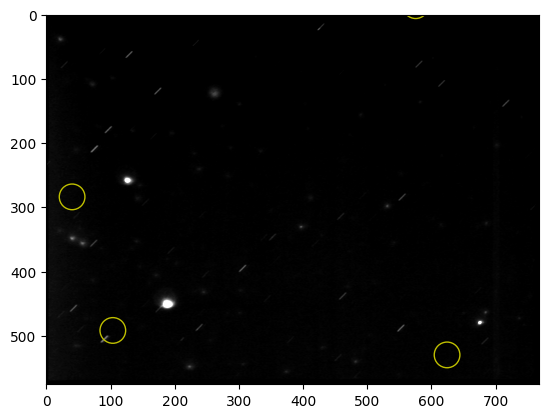

In [ ]:
# Додаємо зміщення по Y на 200, щоб побачити інші координати зір
xy = [[Y[i]+200, X[i]] for i in range(len(X))]
# Draw data
plt.imshow(data, vmin=np.median(data), vmax=3 * np.median(data), cmap="Greys_r")
_ = CircularAperture(xy, r=20.0).plot(color="y")
#plt.colorbar()
plt.show()

<h1>Поворот зображення</h1>

In [18]:
#Для визначення куту повороту ми скористуємося цим співідношенням
r_matrix =  matrix(-(np.pi/2.-center_declination),"y") @ (
            matrix(-center_hour_angle,"z") @ (
            matrix(-(np.pi/2.-fi),"y").transpose() @ (
            matrix(-center_A,"z").transpose() @ matrix(-(np.pi/2.-center_h),"y").transpose())))
r_matrix

array([[ 7.01617457e-01,  7.12553818e-01, -9.90069239e-13],
       [-7.12553818e-01,  7.01617457e-01,  5.61475738e-13],
       [ 9.98889279e-13,  1.87439661e-13,  1.00000000e+00]])

In [ ]:
# Щоб дізнатися кут ми беремо arccos
np.acos(r_matrix[0,0])

np.float64(0.7931314155652325)

In [20]:
xyz.values

array([[-2.30649911e-02,  3.64237473e-02,  9.99070226e-01],
       [-2.27894881e-02,  2.58590909e-02,  9.99405797e-01],
       [ 2.19704251e-02,  3.67015895e-03,  9.99751884e-01],
       [-2.74968566e-02, -7.79043561e-04,  9.99621586e-01],
       [-4.14676389e-04, -4.94373965e-02,  9.98777138e-01],
       [ 1.85055733e-02, -4.36711149e-02,  9.98874555e-01]])

In [22]:
# множимо отримані данні на матрицю повороту
r_xyz = pd.DataFrame((matrix(-np.acos(7.01617457e-01),"z") @ xyz.values.transpose()).transpose(),columns=["x","y","z"])
# Переводимо їх у площину кадру
r_X, r_Y = cartesian_to_plane(r_xyz["x"].values,r_xyz["y"].values,
                             naxis = (head["NAXIS1"],head["NAXIS2"]),
                             fov=np.deg2rad((3,4)), 
                             orientation=(1,1))

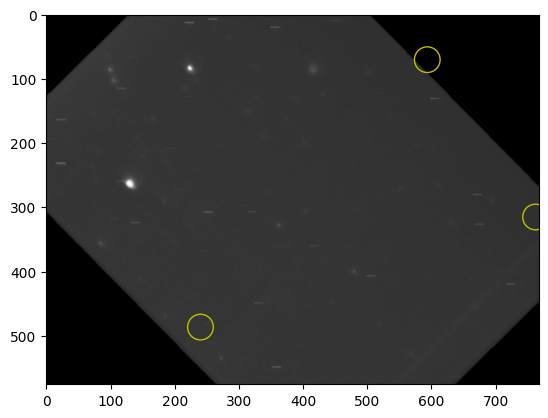

In [ ]:
from scipy import ndimage
from astropy.coordinates import Angle

r_xy = [[r_Y[i], r_X[i]] for i in range(len(X))]
# Повертаємо зображення
rotated = ndimage.rotate(data,-np.rad2deg(np.acos(7.01617457e-01)),reshape=False)
plt.imshow(rotated, cmap="Greys_r")
_ = CircularAperture(r_xy, r=20.0).plot(color="y")


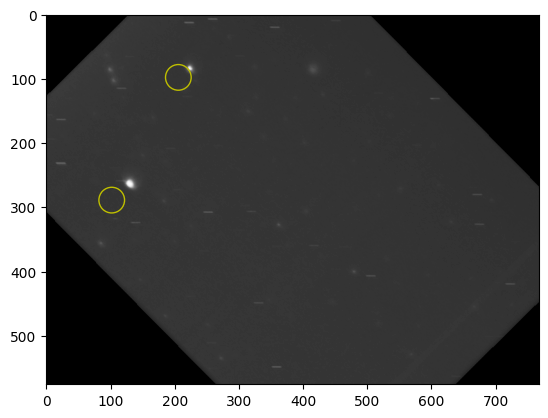

In [32]:
from scipy import ndimage
from astropy.coordinates import Angle

r_xy = [[r_Y[i]+200, r_X[i]+200] for i in range(len(X))]

rotated = ndimage.rotate(data,-np.rad2deg(np.acos(7.01617457e-01)),reshape=False)
plt.imshow(rotated, cmap="Greys_r")
_ = CircularAperture(r_xy, r=20.0).plot(color="y")


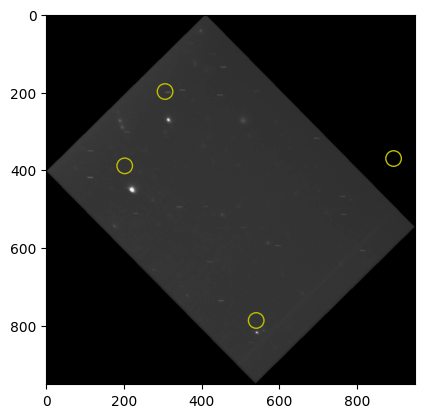

In [35]:
from scipy import ndimage
from astropy.coordinates import Angle

r_xy = [[r_Y[i]+300, r_X[i]+300] for i in range(len(X))]

rotated = ndimage.rotate(data,-np.rad2deg(np.acos(7.01617457e-01)))
plt.imshow(rotated, cmap="Greys_r")
_ = CircularAperture(r_xy, r=20.0).plot(color="y")


In [1]:
from ipyaladin import Aladin

In [ ]:
aladin = Aladin(fov=5)
aladin

In [ ]:
aladin.target = coord